<a href="https://colab.research.google.com/github/encoras/Introduction-to-OpenCV/blob/master/opencv_motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach to Moving Object Detection

https://learnopencv.com/moving-object-detection-with-opencv/

https://www.youtube.com/watch?v=1gi5qn1khVk

In [105]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


inputt = '/content/drive/MyDrive/Colab Notebooks/Camera2.mp4'

capture = cv2.VideoCapture(cv2.samples.findFileOrKeep(inputt))
frame_width = int(capture.get(3))
frame_height = int(capture.get(4))
out = cv2.VideoWriter('DiFF_Background_Subtraction_Tutorial_frame_output.mp4',cv2.VideoWriter_fourcc(*'mp4v'),30, (frame_width,frame_height))

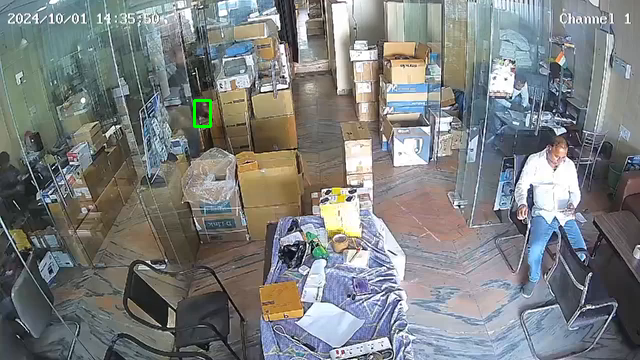

Showing frame #1


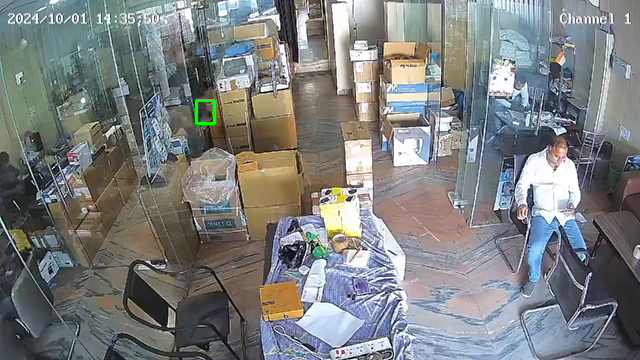

Showing frame #2


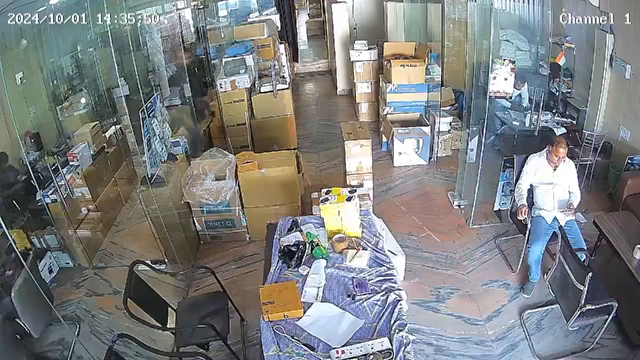

Showing frame #3


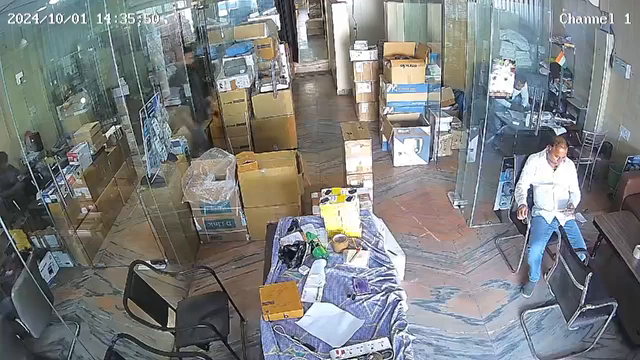

Showing frame #4
End of video / camera error


In [106]:
ret, frame1 = capture.read()
if not ret:
    print("Cannot read first frame")
    # exit or handle error

gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray1 = cv2.GaussianBlur(gray1, (5, 5), 0)

frame_count = 0

while True:
    ret, frame2 = capture.read()
    if not ret:
        print("End of video / camera error")
        break

    frame_count += 1

    # Convert to grayscale
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.GaussianBlur(gray2, (5, 5), 0)

    # Frame differencing
    diff = cv2.absdiff(gray1, gray2)

    # Threshold + noise reduction
    _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(thresh, None, iterations=2)          # fill small gaps

    # Find moving objects
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Make a copy to draw on (clean original)
    display_frame = frame2.copy()

    for contour in contours:
        if cv2.contourArea(contour) < 200:   # adjust this threshold
            continue

        (x, y, w, h) = cv2.boundingRect(contour)

        # Option A: Draw green rectangle (most common for motion detection)
        cv2.rectangle(display_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Option B: If you really want to "white out" the moving region
        # cv2.rectangle(display_frame, (x, y), (x+w, y+h), (255, 255, 255), -1)

        # Optional: add area text
        # cv2.putText(display_frame, f"{cv2.contourArea(contour):.0f}",
        #             (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    if frame_count < 5:
      cv2_imshow(display_frame)   # Colab
      print(f"Showing frame #{frame_count}")
    # cv2.imshow("Motion", display_frame)   # normal python
    out.write(display_frame)
    gray1 = gray2


capture.release()
out.release()

OpenCV tools


In [110]:
#Reset camera frame pointer to 0
capture = cv2.VideoCapture(cv2.samples.findFileOrKeep(inputt))
frame_width = int(capture.get(3))
frame_height = int(capture.get(4))

algo = 'MOG2'

if algo == 'MOG2':
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=False)
    backSub.setShadowThreshold(0.5)
    out = cv2.VideoWriter('MOG_Background_Subtraction_Tutorial_frame_output.mp4',cv2.VideoWriter_fourcc(*'mp4v'),30, (frame_width,frame_height))
else:
    backSub = cv2.createBackgroundSubtractorKNN()
    out = cv2.VideoWriter('KNN_Background_Subtraction_Tutorial_frame_output.mp4',cv2.VideoWriter_fourcc(*'mp4v'),30, (frame_width,frame_height))



In [108]:
def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs:
            fg_mask - foreground mask
            kernel - kernel for Morphological Operations
        Outputs:
            mask - Thresholded mask for moving pixels
        """
    _, thresh = cv2.threshold(fg_mask,min_thresh,255,cv2.THRESH_BINARY)
    motion_mask = cv2.medianBlur(thresh, 5)

    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

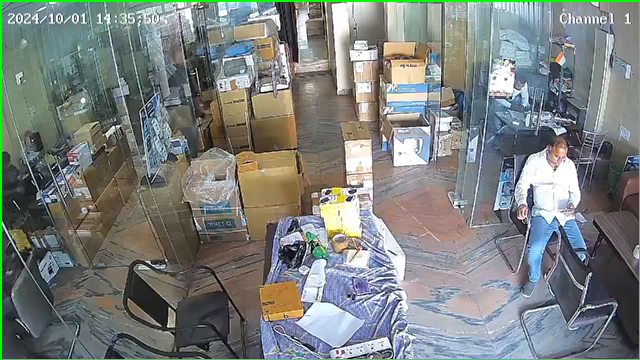

Showing frame #1


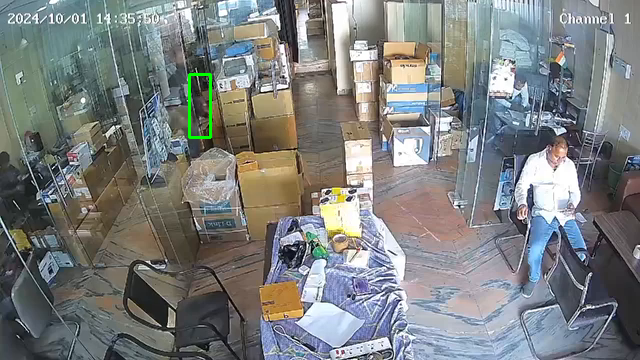

Showing frame #2


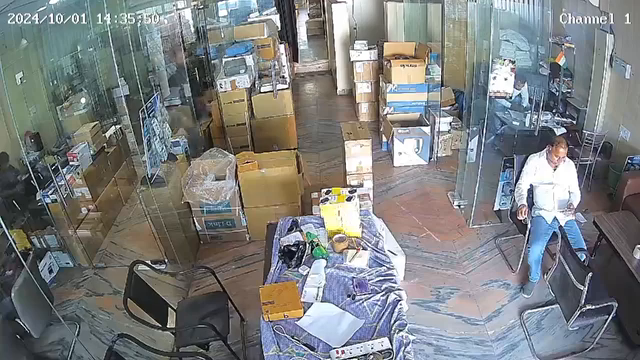

Showing frame #3


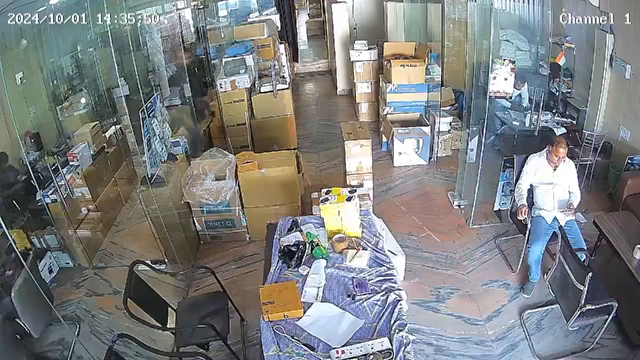

Showing frame #4
End of video


In [111]:
frame_count = 0
while True:
    ret, frame = capture.read()
    if not ret:
        print("End of video")
        break
    frame_count += 1
    # Apply background subtractor
    fgMask = backSub.apply(frame)

    # Get cleaned motion mask
    mask = get_motion_mask(fgMask)

    # Find contours on the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw on COLOR copy of original frame (key fix: was drawing on grayscale mask before)
    display_frame = frame.copy()  # Use frame.copy() instead of mask.copy()

    for contour in contours:
        if cv2.contourArea(contour) < 200:  # Adjust threshold as needed
            continue

        (x, y, w, h) = cv2.boundingRect(contour)

        # Draw green rectangle on color frame
        cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Optional: White out the region (uncomment if wanted)
        # cv2.rectangle(display_frame, (x, y), (x + w, y + h), (255, 255, 255), -1)

        # Optional: Add contour area text
        # cv2.putText(display_frame, f"{cv2.contourArea(contour):.0f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display the result
    if frame_count < 5:
      cv2_imshow(display_frame)   # Colab
      print(f"Showing frame #{frame_count}")

    out.write(display_frame)

# Cleanup
capture.release()
out.release()



